In [8]:
# Сменим рабочую дирректорию для удобства
import os
os.chdir('/home/slawa/HDD/my_scripts/my_otus/ML_advanced/lesson_9/hw')

In [9]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import IsolationForest

In [10]:
# загружаем данные
raw_data_file_name = 'data/raw_data/heart.csv'
raw_data = pd.read_csv(raw_data_file_name, delimiter=',', decimal='.')
raw_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [11]:
# удаляем дубликаты
raw_data.drop_duplicates(inplace=True)

In [12]:
# удаляем мусорные данные
raw_data.drop(raw_data.loc[raw_data['thal'] == 0].index, inplace=True)

In [13]:
# считаем баланс классов
for thal in raw_data['thal'].unique():
    count = raw_data.loc[raw_data['thal'] == thal].shape[0]
    count_percent = count / raw_data.shape[0] * 100
    print(f'class {thal}: count {count}, percent {count_percent:.2f}%')

class 3: count 117, percent 39.00%
class 2: count 165, percent 55.00%
class 1: count 18, percent 6.00%


In [14]:
# прячем часть данных для финальной проверки
data_train, data_test = train_test_split(raw_data, test_size=0.1, stratify=raw_data['thal'])
data_test.to_csv('data/test_data/test_clear_disbalance.csv', index=False)

In [15]:
# считаем баланс классов в оставшемся датасете
for thal in data_train['thal'].unique():
    count = data_train.loc[data_train['thal'] == thal].shape[0]
    count_percent = count / data_train.shape[0] * 100
    print(f'class {thal}: count {count}, percent {count_percent:.2f}%')

class 2: count 149, percent 55.19%
class 3: count 105, percent 38.89%
class 1: count 16, percent 5.93%


In [16]:
# бьем оставшуюся выборку
df_train, df_test = train_test_split(data_train, test_size=0.2, stratify=data_train['thal'])

In [17]:
# считаем баланс классов в оставшемся датасете
for thal in df_train['thal'].unique():
    count = df_train.loc[df_train['thal'] == thal].shape[0]
    count_percent = count / df_train.shape[0] * 100
    print(f'class {thal}: count {count}, percent {count_percent:.2f}%')

class 3: count 84, percent 38.89%
class 1: count 13, percent 6.02%
class 2: count 119, percent 55.09%


In [18]:
# разобьем поля по их типам
target_col = ['thal']
categorical_col = ['cp', 'restecg', 'slope']
numeric_col = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
binary_col = ['sex', 'fbs', 'exang', 'target']
all_features = categorical_col + numeric_col + binary_col

In [19]:
# собираем данные для обучения
X_train_df = df_train[all_features]
Y_train_df = df_train[target_col]
X_test_df = df_test[all_features]
Y_test_df = df_test[target_col]
print(f'train: X{X_train_df.shape}, Y{Y_train_df.shape}')
print(f'test: X{X_test_df.shape}, Y{Y_test_df.shape}')

train: X(216, 13), Y(216, 1)
test: X(54, 13), Y(54, 1)


In [20]:
# собираем конвейер предобработки данных
data_transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_col),
        ('scaler', StandardScaler(), numeric_col),
        ("as_is", "passthrough", binary_col)
    ]
)
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

In [21]:
# обучаем препроцессор
preprocessor.fit(X_train_df)

Pipeline(steps=[('data_transformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cp', 'restecg', 'slope']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca']),
                                                 ('as_is', 'passthrough',
                                                  ['sex', 'fbs', 'exang',
                                                   'target'])]))])

In [22]:
# трансформируем данные для обучения в массив
X_train_array = preprocessor.transform(X_train_df)
X_train_array.shape

(216, 20)

In [23]:
# трансформируем данные для теста в массив
X_test_array = preprocessor.transform(X_test_df)
X_test_array.shape

(54, 20)

In [24]:
# Данные для ae
X_train_array_ae = preprocessor.transform(X_train_df.drop(Y_train_df[Y_train_df['thal'] == 1].index))
X_test_array_ae = preprocessor.transform(X_test_df.drop(Y_test_df[Y_test_df['thal'] == 1].index))
print(X_train_array_ae.shape)
print(X_test_array_ae.shape)

(203, 20)
(51, 20)


In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import mae
from tensorflow.keras.saving import load_model

2024-04-05 03:13:37.498356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 03:13:43.158832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
m_ch = ModelCheckpoint(
    'models/ae.weights.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [27]:
latent = 10

en_in = Input((X_train_array.shape[1],))
en_x = Dense(256, activation='relu', kernel_regularizer=l2)(en_in)
en_x = BatchNormalization()(en_x)
en_out = Dense(latent)(en_x)
en = Model(en_in, en_out) 

dec_in = Input((latent,))
dec_x = Dense(256, activation='relu', kernel_regularizer=l2)(dec_in)
dec_x = BatchNormalization()(dec_x)
dec_out = Dense(X_train_array.shape[1])(dec_x)
dec = Model(dec_in, dec_out) 

ae = Model(en_in, dec(en(en_in)))
ae.summary()

2024-04-05 03:13:46.454252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-05 03:13:46.471854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-05 03:13:46.472023: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 10)             │         8,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 20)             │         8,980 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,950 (70.12 KB)

 Trainable params: 16,926 (66.12 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [28]:
ae.compile(loss='mse', optimizer=Adam(0.0001))

Epoch 1/300


I0000 00:00:1712258027.809927 2023063 service.cc:145] XLA service 0x72e30400c340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712258027.809943 2023063 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-04-05 03:13:47.842646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-05 03:13:47.980883: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 2.9436

I0000 00:00:1712258028.619486 2023063 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.8005
Epoch 1: val_loss improved from inf to 1.05810, saving model to models/ae.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 2.7942 - val_loss: 1.0581
Epoch 2/300
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5000
Epoch 2: val_loss improved from 1.05810 to 1.05244, saving model to models/ae.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4705 - val_loss: 1.0524
Epoch 3/300
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.2600
Epoch 3: val_loss improved from 1.05244 to 1.04756, saving model to models/ae.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2486 - val_loss: 1.0476
Epoch 4/300
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9927
Epoch 4: val_loss improved from 1.04756 to 1.04315, saving model to models/ae.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0142 - val_loss: 1.0432
Epoch 5/300
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8595
Epoch 5: val_loss improved from

[]

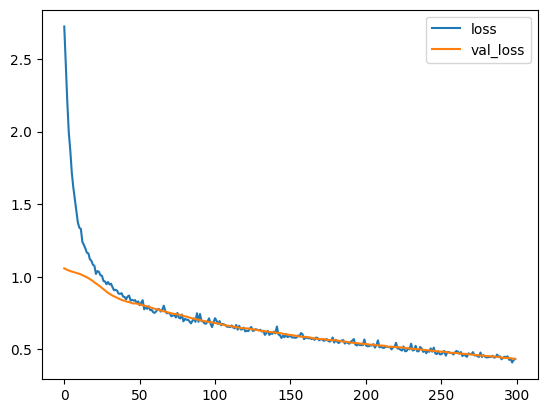

In [29]:
history = ae.fit(
    X_train_array_ae,
    X_train_array_ae,
    batch_size=20,
    epochs=300,
    validation_data=(X_test_array_ae, X_test_array_ae),
    verbose=1,
    callbacks=[m_ch,]
)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.plot()

In [30]:
ae.load_weights('models/ae.weights.h5')

In [31]:
ae.predict(X_test_array_ae)[0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


array([ 1.0041558 ,  0.07256062,  0.07299767,  0.27954596,  0.8574281 ,
       -0.04625408,  0.17849809,  0.11333622,  0.8993934 , -0.20964625,
        1.1319356 ,  0.32250768,  0.25235957, -1.185437  ,  1.211183  ,
        0.5338946 ,  0.5521431 ,  0.24509533,  0.5874618 ,  0.04869885],
      dtype=float32)

In [32]:
X_test_array_ae.shape

(51, 20)

In [33]:
mae(X_test_array_ae, ae.predict(X_test_array_ae)).numpy()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([0.18051574, 0.16448244, 0.20213732, 0.20280516, 0.4246544 ,
       0.25046414, 0.26430535, 0.20079891, 0.18564999, 0.39777574,
       0.17953944, 0.23599248, 0.19300196, 0.30468526, 0.23194873,
       0.17492807, 0.43299198, 0.30737814, 0.21751365, 0.2692039 ,
       0.15873882, 0.40256128, 0.3445053 , 0.2740209 , 0.22779398,
       0.13037768, 0.2668004 , 0.28775677, 0.14374371, 0.16997485,
       0.19036564, 0.17502731, 0.13804868, 0.30678263, 0.21879634,
       0.37217784, 0.27873826, 0.39889577, 0.29891986, 0.1972179 ,
       0.26197138, 0.12940493, 0.31087494, 0.34212106, 0.39825106,
       0.17785569, 0.1942487 , 0.3606307 , 0.22384813, 0.2659815 ,
       0.20175175], dtype=float32)

In [34]:
mae(X_test_array, ae.predict(X_test_array)).numpy()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


array([0.18051574, 0.16448244, 0.34872466, 0.20213732, 0.20280516,
       0.4246544 , 0.25046414, 0.26430535, 0.20079891, 0.18564999,
       0.39777574, 0.17953944, 0.23599248, 0.19300196, 0.30468526,
       0.23194873, 0.17492807, 0.43299198, 0.30737814, 0.21315369,
       0.21751365, 0.2692039 , 0.15873882, 0.40256128, 0.3445053 ,
       0.2740209 , 0.22779398, 0.13037768, 0.2668004 , 0.4521196 ,
       0.28775677, 0.14374371, 0.16997486, 0.19036558, 0.17502734,
       0.13804862, 0.30678266, 0.21879634, 0.37217784, 0.27873817,
       0.3988958 , 0.29891986, 0.1972178 , 0.26197132, 0.12940486,
       0.310875  , 0.3421211 , 0.39825112, 0.17785569, 0.1942487 ,
       0.3606307 , 0.22384815, 0.26598153, 0.20175183], dtype=float32)

In [35]:
mae(
    preprocessor.transform(
        X_test_df.drop(
            Y_test_df[Y_test_df['thal'] != 1].index)
        ), 
        ae.predict(
            preprocessor.transform(
                X_test_df.drop(Y_test_df[Y_test_df['thal'] != 1].index)
            )
        )
).numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([0.34872463, 0.21315375, 0.45211953], dtype=float32)

In [36]:
en.predict(X_test_array).shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


(54, 10)